In [1]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, MeanSquaredError
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.metrics import MeanAbsoluteError

In [3]:
df_1 = pd.read_csv(r"C:\Users\flore\OneDrive\Documents\CSUN\Fall24\COMP_541\Project\VideoGame\games.csv")

In [4]:
df_2 = pd.read_csv(r"C:\Users\flore\OneDrive\Documents\CSUN\Fall24\COMP_541\Project\VideoGame\all_games.csv")

In [5]:
df_1.columns = ['Name','Release date','Estimated Owners','Peak CCU','Required age','Price','Unknown1',
              'Unknown2','About the game','Supported languages','Full audio languages','Reviews','Header Image','Website',
              'Support url','Support email','Windows','Mac', 'Linux','User score','Metacritic url'
              ,'Positive','Negative','Score rank','Achievements','Recommendations','Unknown3','Notes',
              'Average playtime forever','Average playtime two weeks','Median playtime forever','Median playtime two weeks',
              'Developers','Publishers','Categories','Genres','Tags','Screenshots','Movies']

In [6]:
df_2.columns = ['Name','Platform','Release Date','Summary','Meta Score','User Review']

In [7]:
df_1 = df_1.drop(['Developers','User score','Average playtime forever','Average playtime two weeks','Median playtime forever','Median playtime two weeks','Recommendations','Estimated Owners','About the game','Reviews','Unknown1','Unknown2','Unknown3', 'Supported languages','Full audio languages','Header Image' ,'Website', 'Support url', 'Support email', 'Notes', 'Metacritic url', 'Achievements', 'Screenshots', 'Movies','Publishers','Categories','Tags'], axis=1)

In [8]:
df_2 = df_2.drop(['Summary','Release Date','Platform'], axis=1)

In [9]:
VG_dataset = pd.merge(df_1, df_2, on='Name', how='inner')

In [10]:
len_VG_dataset = len(VG_dataset)
print(f"Number of matching instances in 'Name': {len_VG_dataset}")

Number of matching instances in 'Name': 5860


In [11]:
print(VG_dataset.isna().sum())

Name            0
Release date    0
Peak CCU        0
Required age    0
Price           0
Windows         0
Mac             0
Linux           0
Positive        0
Negative        0
Score rank      0
Genres          3
Meta Score      0
User Review     0
dtype: int64


In [12]:
VG_dataset = VG_dataset.dropna()

In [13]:
VG_dataset = VG_dataset.drop(['Name'], axis = 1)

In [14]:
VG_dataset = VG_dataset[VG_dataset['User Review'] != 'tbd']
VG_dataset.loc[:, 'User Review'] = pd.to_numeric(VG_dataset['User Review'], errors='coerce')

In [15]:
VG_dataset.shape

(5463, 13)

In [16]:
VG_dataset['Release date'] = VG_dataset['Release date'].str.extract(r'(\d{4})')
VG_dataset['Release date'] = pd.to_numeric(VG_dataset['Release date'], errors='coerce')
VG_dataset = VG_dataset[VG_dataset['Release date'] >= 2014]

In [17]:
len_VG_filter_by_year = len(VG_dataset)
print(f"Number of Games instances release after 2014': {len_VG_filter_by_year}")

Number of Games instances release after 2014': 4204


In [18]:
VG_dataset['Genres'] = VG_dataset['Genres'].str.split(',')
unique_tags = set(tag for sublist in VG_dataset['Genres'] for tag in sublist)
one_hot_encoded_genres = VG_dataset['Genres'].str.join('|').str.get_dummies()
VG_dataset = pd.concat([VG_dataset, one_hot_encoded_genres], axis=1)
VG_dataset.drop('Genres', axis=1, inplace=True) #don't need 'Genres' feature any more

In [19]:
Q1 = VG_dataset['Negative'].quantile(0.25)
Q3 = VG_dataset['Negative'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
VG_outliers_filter = VG_dataset[(VG_dataset['Negative'] >= lower_bound) & (VG_dataset['Negative'] <= upper_bound)]

In [20]:
total_outliers = len(VG_dataset) - len(VG_outliers_filter)
print(f"Lower Bound: {lower_bound}")
print(f"Upper Bound: {upper_bound}")
print(f"Total Number of Outliers: {total_outliers}")

Lower Bound: -7573.5
Upper Bound: 13376.5
Total Number of Outliers: 601


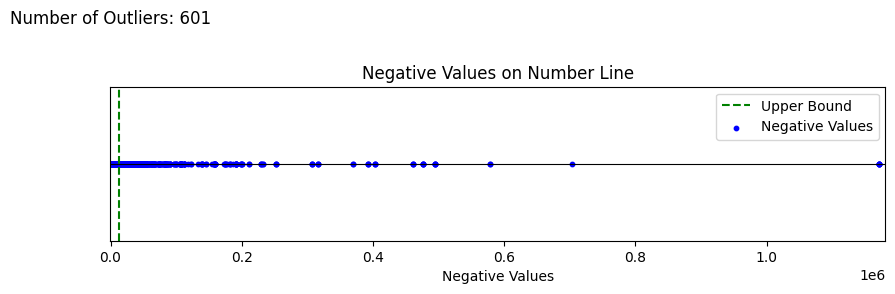

In [21]:
plt.figure(figsize=(10, 2))
plt.title("Negative Values on Number Line")
plt.axhline(0, color='black', lw=0.8)  
plt.text(0, 0.1, f'Number of Outliers: {total_outliers}', fontsize=12, ha='center', color='black')
plt.axvline(upper_bound, color='green', linestyle='--', label='Upper Bound')
plt.scatter(VG_dataset['Negative'], np.zeros(len(VG_dataset)), color='blue', label='Negative Values', s=10)
plt.xlim(VG_dataset['Negative'].min() - 100, VG_dataset['Negative'].max()+10000)  # x-axis limits
plt.yticks([])  
plt.xlabel("Negative Values")
plt.legend()
plt.grid(False)
plt.show()

In [22]:
VG_dataset = VG_outliers_filter

In [23]:
scaler = MinMaxScaler()
normalization_data = scaler.fit_transform(VG_dataset[['Release date', 'Peak CCU','Required age','Price', 'Positive', 'Negative','Score rank','Meta Score','User Review']])
VG_dataset[['Release date', 'Peak CCU','Required age','Price', 'Positive', 'Negative', 'Score rank','Meta Score','User Review']] = normalization_data

In [24]:
genre_columns = VG_dataset.columns[12:]
threshold = 0.10 * len(VG_dataset)
filtered_genres = [col for col in genre_columns if VG_dataset[col].sum() >= threshold]
columns_to_keep = VG_dataset.columns[1:12].tolist() + filtered_genres
VG_dataset = VG_dataset[columns_to_keep]

In [25]:
unique_windows = VG_dataset['Windows'].unique()
print(unique_windows)

[ True]


In [26]:
# Remove the feature 'Window' because all the instance has the same value 
# redundant feature 
VG_dataset= VG_dataset.drop(['Windows'], axis=1)

In [27]:
correlation_matrix = VG_dataset.corr()
meta_score_correlation = correlation_matrix['Meta Score']
print("Correlation with 'Meta Score':")
print(meta_score_correlation)

Correlation with 'Meta Score':
Peak CCU        0.104863
Required age   -0.095434
Price           0.102509
Mac             0.115031
Linux           0.104825
Positive        0.003955
Negative        0.274834
Score rank      0.026549
Meta Score      1.000000
User Review     0.520786
Action         -0.049638
Adventure       0.003599
Casual         -0.006718
Indie           0.057537
RPG             0.057553
Simulation     -0.009676
Strategy        0.023366
Name: Meta Score, dtype: float64


In [28]:
low_correlation_features = meta_score_correlation[abs(meta_score_correlation) < 0.015].index.tolist()
VG_dataset.drop(columns=low_correlation_features, inplace=True)

In [29]:
VG_dataset.head()

,Peak CCU,Required age,Price,Mac,Linux,Negative,Score rank,Meta Score,User Review,Action,Indie,RPG,Strategy
11,0.000070,0.000000,0.074954,False,False,0.015675,0.007046,0.657534,0.800000,1,1,1,0
12,0.000279,0.000000,0.004950,False,False,0.157731,0.034584,0.821918,0.400000,1,1,0,0
13,0.000279,0.000000,0.004950,False,False,0.157731,0.034584,0.739726,0.547368,1,1,0,0
16,0.000070,0.000000,0.124956,False,False,0.031804,0.010569,0.397260,0.484211,0,1,0,0
17,0.003175,0.722222,0.199960,False,False,0.160003,0.008988,0.794521,0.852632,0,0,1,0


In [30]:
VG_dataset.shape

(3603, 13)

In [31]:
y =VG_dataset['Meta Score']

In [32]:
X = VG_dataset.drop(['Meta Score'], axis=1)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [34]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)  
])

C:\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [35]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=MeanSquaredError(),          
    metrics=[MeanAbsoluteError()]       
)

In [36]:
history = model.fit(
    X_train,
    y_train,
    epochs=100,               
    batch_size=32,           
    validation_data=(X_test, y_test) 
)

Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2652 - mean_absolute_error: 0.3532 - val_loss: 0.0231 - val_mean_absolute_error: 0.1250
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0546 - mean_absolute_error: 0.1803 - val_loss: 0.0211 - val_mean_absolute_error: 0.1215
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0378 - mean_absolute_error: 0.1515 - val_loss: 0.0220 - val_mean_absolute_error: 0.1238
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0311 - mean_absolute_error: 0.1361 - val_loss: 0.0205 - val_mean_absolute_error: 0.1195
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0275 - mean_absolute_error: 0.1267 - val_loss: 0.0219 - val_mean_absolute_error: 0.1265
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0261 - mean_absolute_error: 0.1207 - val_loss: 0.0209 - val_mean_absolute_error: 0.1235
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0200 - mean_absolute_error: 0.1116 - val_loss

In [37]:
predictions = model.predict(X_test)
y_train_pred = model.predict(X_train)

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step


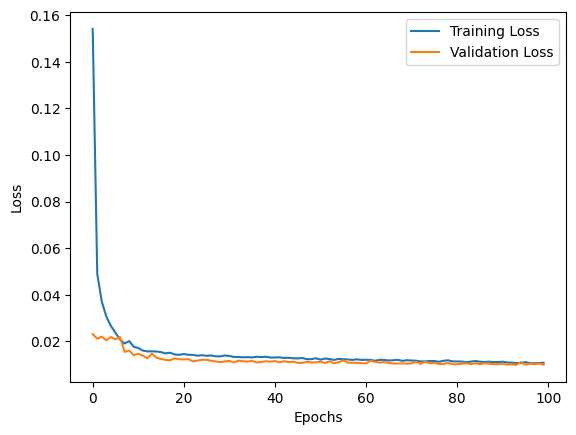

In [38]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [39]:
MSE = mean_squared_error(y_test, predictions)
MAE = mean_absolute_error(y_test, predictions)
print("MSE: ", MSE)
print("MAE: ", MAE )
print("R sqaure: ",  r2_score(y_test, predictions))

MSE:  0.009988025249292324
MAE:  0.07822666159843933
R sqaure:  0.4216209800291377


In [40]:
train_accuracy = r2_score(y_train, y_train_pred)
test_accuracy = r2_score(y_test, predictions)

print("Train Accuracy (R^2):", train_accuracy)
print("Test Accuracy (R^2):", test_accuracy)

Train Accuracy (R^2): 0.5452916083988156
Test Accuracy (R^2): 0.4216209800291377
